In [1]:
%pip install numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os                 # file paths & folders
import csv                # write CSV tables
import numpy as np        # simple numeric work
import matplotlib.pyplot as plt  # plotting (appears inline in Jupyter)

In [3]:
import os

ROOT = os.getcwd()
DATA = os.path.join(ROOT, "data")
FIGS = os.path.join(ROOT, "figures")
RES  = os.path.join(ROOT, "results")

os.makedirs(DATA, exist_ok=True)
os.makedirs(FIGS, exist_ok=True)
os.makedirs(RES,  exist_ok=True)

ROOT, DATA, FIGS, RES


('/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project',
 '/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/data',
 '/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/figures',
 '/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/results')

In [4]:
header = ">example_synthetic_sequence"
# three 1,000-bp blocks: mixed, GC-rich, AT-rich
block1 = "ATGC" * 250      # 4 bases × 250 = 1000 bp (balanced)
block2 = "GCGC" * 250      # GC-rich 1000 bp
block3 = "ATAT" * 250      # AT-rich 1000 bp
sequence = block1 + block2 + block3

fasta_path = os.path.join(DATA, "example_sequence.fasta")
with open(fasta_path, "w") as fh:
    fh.write(header + "\n")
    # wrap sequence to 60 chars per line (FASTA style)
    for i in range(0, len(sequence), 60):
        fh.write(sequence[i:i+60] + "\n")

fasta_path

'/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/data/example_sequence.fasta'

In [5]:
import os

# assume you already created a "data" folder with Step 2
fasta_path = os.path.join(os.getcwd(), "data", "example_sequence.fasta")
print(fasta_path)

def read_fasta_single(path):
    header = None
    parts = []
    with open(path, "r") as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                header = line[1:].strip()
            else:
                parts.append(line.replace(" ", "").upper())
    seq = "".join(parts)
    return header, seq

hdr, seq = read_fasta_single(fasta_path)
len(hdr) if hdr else hdr, len(seq), seq[:60] + ("..." if len(seq) > 60 else "")


/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/data/example_sequence.fasta


(26, 3000, 'ATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGC...')

In [6]:
def gc_fraction(dna):
    dna = dna.upper()
    gc = sum(1 for b in dna if b in ("G", "C"))
    acgt = sum(1 for b in dna if b in ("A", "C", "G", "T"))
    return (gc / acgt) if acgt > 0 else 0.0

def sliding_windows(dna, window=200, step=100):
    n = len(dna)
    i = 0
    while i < n:
        j = i + window
        if j > n:
            j = n
        yield (i, j, dna[i:j])
        if j == n:
            break
        i += step

def gc_profile(dna, window=200, step=100):
    rows = []
    for start, end, sub in sliding_windows(dna, window=window, step=step):
        gc_pct = gc_fraction(sub) * 100.0
        rows.append({"start": start, "end": end, "length": end - start, "gc_percent": gc_pct})
    return rows

overall_gc = gc_fraction(seq) * 100.0
rows = gc_profile(seq, window=200, step=100)

len(rows), overall_gc, rows[:3]


(29,
 50.0,
 [{'start': 0, 'end': 200, 'length': 200, 'gc_percent': 50.0},
  {'start': 100, 'end': 300, 'length': 200, 'gc_percent': 50.0},
  {'start': 200, 'end': 400, 'length': 200, 'gc_percent': 50.0}])

In [7]:
import csv

csv_path = os.path.join(RES, "gc_windows.csv")
with open(csv_path, "w", newline="") as fh:
    writer = csv.DictWriter(fh, fieldnames=["start", "end", "length", "gc_percent"])
    writer.writeheader()
    for r in rows:
        writer.writerow(r)

csv_path


'/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/results/gc_windows.csv'

'/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/figures/gc_profile.png'

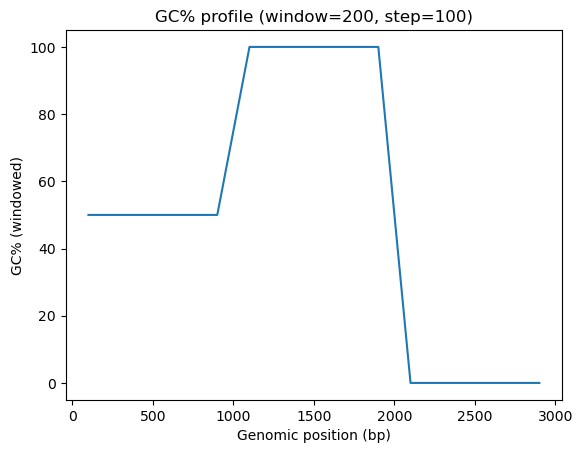

In [8]:
import numpy as np
import matplotlib.pyplot as plt

xs = [ (r["start"] + r["end"]) / 2 for r in rows ]  # window midpoints
ys = [ r["gc_percent"] for r in rows ]

plt.figure()
plt.plot(xs, ys)
plt.xlabel("Genomic position (bp)")
plt.ylabel("GC% (windowed)")
plt.title(f"GC% profile (window=200, step=100)")
fig_path1 = os.path.join(FIGS, "gc_profile.png")
plt.savefig(fig_path1, dpi=200, bbox_inches="tight")
fig_path1


'/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/figures/gc_overall.png'

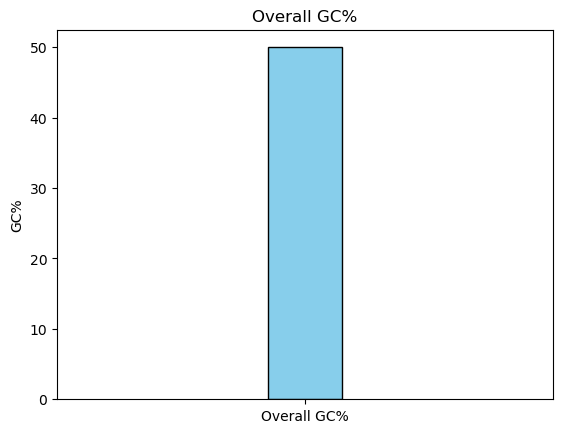

In [14]:
plt.figure()
plt.bar([0], [overall_gc], width=0.3, color="skyblue", edgecolor="black")
plt.xticks([0], ["Overall GC%"])
plt.ylabel("GC%")
plt.title("Overall GC%")

# expand the x-axis to make the bar thinner visually
plt.xlim(-1, 1)  

fig_path2 = os.path.join(FIGS, "gc_overall.png")
plt.savefig(fig_path2, dpi=200, bbox_inches="tight")
fig_path2


In [15]:
K = 10
rows_sorted = sorted(rows, key=lambda r: r["gc_percent"])
lowest = rows_sorted[:K]
highest = rows_sorted[-K:][::-1]

extreme_path = os.path.join(RES, "gc_extremes.csv")
with open(extreme_path, "w", newline="") as fh:
    import csv
    w = csv.DictWriter(fh, fieldnames=["which","rank","start","end","length","gc_percent"])
    w.writeheader()
    for i, r in enumerate(lowest, start=1):
        w.writerow({"which":"lowest", "rank":i, **r})
    for i, r in enumerate(highest, start=1):
        w.writerow({"which":"highest", "rank":i, **r})

extreme_path, lowest[:3], highest[:3]


('/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/results/gc_extremes.csv',
 [{'start': 2000, 'end': 2200, 'length': 200, 'gc_percent': 0.0},
  {'start': 2100, 'end': 2300, 'length': 200, 'gc_percent': 0.0},
  {'start': 2200, 'end': 2400, 'length': 200, 'gc_percent': 0.0}],
 [{'start': 1800, 'end': 2000, 'length': 200, 'gc_percent': 100.0},
  {'start': 1700, 'end': 1900, 'length': 200, 'gc_percent': 100.0},
  {'start': 1600, 'end': 1800, 'length': 200, 'gc_percent': 100.0}])

In [2]:
import os, datetime  # import: bring modules into this cell; 'os' = filesystem tools, 'datetime' = dates
# The comma separates two module names in one import statement.

root = os.getcwd()  # 'root' (variable name) = current working directory (folder where this notebook lives)
# '=' assigns the value on the right to the name on the left.
# os.getcwd() calls (parentheses) the function that returns the current path as a string.

readme_path = os.path.join(root, "README.md")
# os.path.join safely builds a path string from pieces (handles Windows/macOS separators).
# "README.md" is the filename we want to create.

fig1_rel = os.path.join("figures", "gc_profile.png")
fig2_rel = os.path.join("figures", "gc_overall.png")
table_rel = os.path.join("results", "gc_windows.csv")
# These are *relative* paths (from repo root). GitHub uses these to show images/files in the README.

# ---- Build a tiny markdown table snippet from the first few CSV rows ----
snippet_lines = []  # empty list to collect lines of markdown text
max_rows = 5        # show at most 5 data rows in the README table (adjust if you like)

# Add a markdown table header:
snippet_lines.append("| start | end | length | gc_percent |")   # first header row with column names
snippet_lines.append("|---:|---:|---:|---:|")                    # second header row with alignment (':' right-align numbers)

# If the CSV exists, read its first few rows; else, put one placeholder row.
if os.path.exists(table_rel):                       # if the file at 'table_rel' exists (True/False)
    with open(table_rel, "r", newline="") as fh:    # open the CSV file for reading; 'fh' = file handle
        header = fh.readline()                      # read and discard the CSV header line (we already wrote our own)
        for _ in range(max_rows):                   # underscore '_' means we ignore the loop index
            line = fh.readline()                    # read one data line; returns '' (empty) at end-of-file
            if not line:                            # if the line is empty (Falsey), stop early
                break                               # exit the for-loop
            start, end, length, gc = line.strip().split(",")  # strip newline, then split by comma into 4 strings
            snippet_lines.append(f"| {start} | {end} | {length} | {gc} |")  # f-string builds one markdown row
else:
    snippet_lines.append("| 0 | 200 | 200 | 50.0 |")  # fallback example row if CSV missing

snippet_md = "\n".join(snippet_lines)  # join list of lines into one string with newline separators

# Try to show your computed overall GC% if it's defined in this kernel; otherwise write a placeholder.
try:
    overall_gc_str = f"{overall_gc:.1f}%"  # format overall_gc to 1 decimal place and add a % sign
except NameError:
    overall_gc_str = "(compute in notebook)"  # shown if 'overall_gc' variable doesn't exist

# Build the README markdown body as one big f-string (we inject today's date and paths/values).
readme_md = f"""# GC Content + Sliding Window (Publishable Mini-Project)

**Updated:** {datetime.date.today().isoformat()}

## Goal
Compute overall GC% and a sliding-window GC profile for a DNA sequence (FASTA), then save figures and tables that others can reuse.

## Methods (brief)
- **Overall GC%** = (count of G or C) / (count of A/C/G/T) × 100.
- **Sliding windows**: walk along the sequence in fixed-size windows and compute GC% per window.

## Results (quick look)
**Overall GC%:** {overall_gc_str}

GC% profile:

![GC profile]({fig1_rel})

Overall GC% bar:

![Overall GC]({fig2_rel})

First few windows:

{snippet_md}

"""

# Write the README file to disk.
with open(readme_path, "w", encoding="utf-8") as fh:  # open file for writing text; 'encoding' ensures Unicode-safe write
    fh.write(readme_md)                               # write the full markdown string to the file

readme_path  # final expression so Jupyter prints the path; click it to preview/download


'/home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/README.md'

In [5]:
from IPython.display import Markdown, display  # import renderer tools

with open("README.md", "r", encoding="utf-8") as fh:  # open README.md for reading
    md_text = fh.read()                              # read file content as one string
display(Markdown(md_text))                           # tell Jupyter: render as Markdown


# GC Content + Sliding Window (Publishable Mini-Project)

**Updated:** 2025-08-26

## Goal
Compute overall GC% and a sliding-window GC profile for a DNA sequence (FASTA), then save figures and tables that others can reuse.

## Methods (brief)
- **Overall GC%** = (count of G or C) / (count of A/C/G/T) × 100.
- **Sliding windows**: walk along the sequence in fixed-size windows and compute GC% per window.

## Results (quick look)
**Overall GC%:** 50.0%

GC% profile:

![GC profile](figures/gc_profile.png)

Overall GC% bar:

![Overall GC](figures/gc_overall.png)

First few windows:

| start | end | length | gc_percent |
|---:|---:|---:|---:|
| 0 | 200 | 200 | 50.0 |
| 100 | 300 | 200 | 50.0 |
| 200 | 400 | 200 | 50.0 |
| 300 | 500 | 200 | 50.0 |
| 400 | 600 | 200 | 50.0 |


## Next Steps
We extended the analysis by running the pipeline on **real FASTA sequences**:
- Human mitochondrial genome (rCRS, NC_012920.1)
- *Escherichia coli* K-12 MG1655 (NC_000913.3)

This produced updated GC% profiles and tables in the `results/` folder.

## Data Sources
- **Human mitochondrion (rCRS)** — NCBI RefSeq **NC_012920.1**  
  FASTA viewer: https://www.ncbi.nlm.nih.gov/sviewer/viewer.fcgi?id=NC_012920.1&db=nuccore&report=fasta
- **Escherichia coli K-12 substr. MG1655** — NCBI RefSeq **NC_000913.3**  
  FASTA viewer: https://www.ncbi.nlm.nih.gov/sviewer/viewer.fcgi?id=NC_000913.3&db=nuccore&report=fasta

*This section was appended on 2025-08-27 to cite sequence sources used in analyses.*


In [1]:
# GC content analysis for real FASTA files
# -------------------------------
# CREATE FOLDERS FOR DATA/RESULTS
# -------------------------------

# 'import' is a Python keyword that loads code from a module (a reusable library).
# 'pathlib' is a standard library module that gives us object-based filesystem paths
#   (nicer than plain strings).
from pathlib import Path  # 'from ... import ...' brings only 'Path' into our namespace.

# 'Path()' creates a path object pointing to the *current working directory* by default.
# '.resolve()' converts it to an absolute path (no '..' pieces).
BASE = Path().resolve()  # We use ALL-CAPS to show this is a constant-like "configuration" variable.

# We build a list of directories we want to ensure exist.
# 'BASE / "data"' uses the '/' operator overloaded by Path to join paths (equivalent to os.path.join).
dirs_to_make = [
    BASE / "data",              # will hold FASTA files we download or add manually
    BASE / "results" / "mtDNA", # will hold outputs for the human mitochondrion run
    BASE / "results" / "ecoli", # will hold outputs for the E. coli run
]

# 'for' starts a loop; 'p' is our loop variable (each element of 'dirs_to_make' in turn).
# '.mkdir(...)' actually creates the directory.
# 'parents=True' means create any missing parent folders (e.g., create 'results' before 'results/mtDNA').
# 'exist_ok=True' means *don’t error* if the folder already exists (idempotent/safe).
for p in dirs_to_make:
    p.mkdir(parents=True, exist_ok=True)


In [3]:
# --------------------------------------
# DOWNLOAD FASTA(S) AUTOMATICALLY
# --------------------------------------
# This cell uses urllib to fetch the FASTA directly from NCBI viewer "FASTA" endpoints.

import urllib.request  # 'urllib.request' provides 'urlretrieve' to download a URL to a local file.

# We define a tiny helper function with explicit parameters and verbose comments.
def fetch(url: str, out_path: str) -> None:
    """
    Download a file from 'url' to local file 'out_path'.
    - 'url' (type: str) is the web address to download from.
    - 'out_path' (type: str) is where to save the file locally.
    Returns nothing (None) but writes the file to disk.
    """
    # 'urllib.request.urlretrieve' actually performs the download
    #  1st argument: the URL string
    #  2nd argument: the destination path string
    # It will create/overwrite 'out_path' with the downloaded content.
    urllib.request.urlretrieve(url, out_path)

# Human mitochondrion (rCRS) FASTA "viewer" URL:
mt_url = (
    "https://www.ncbi.nlm.nih.gov/sviewer/viewer.fcgi"
    "?id=NC_012920.1&db=nuccore&report=fasta"  # query string picks db and 'fasta' format
)
# E. coli MG1655 FASTA "viewer" URL:
ecoli_url = (
    "https://www.ncbi.nlm.nih.gov/sviewer/viewer.fcgi"
    "?id=NC_000913.3&db=nuccore&report=fasta"
)

# Build output paths inside our repo structure, using Path for correctness across OSes.
mt_out   = (BASE / "data" / "human_mtDNA_NC_012920.1.fasta").as_posix()  # '.as_posix()' -> clean "path/to" string
ec_out   = (BASE / "data" / "Ecoli_MG1655_NC_000913.3.fna").as_posix()

# Actually fetch the files.
fetch(mt_url, mt_out)
fetch(ecoli_url, ec_out)

print("Downloaded:")
print(" -", mt_out)
print(" -", ec_out)


Downloaded:
 - /home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/data/human_mtDNA_NC_012920.1.fasta
 - /home/f2ba0ff0-aa7c-4010-bd78-4611604e113c/gc-project/data/Ecoli_MG1655_NC_000913.3.fna
